# № 3 Продажи по будням и выходным.

**Определение гипотез**  

H₀: Средний объём продаж по будням и выходным одинаковый.  
H₁: Есть статистически значимые различия в продажах по будням и по выходным.  

**Тесты**  
- Mann–Whitney U-test
    - Размер эффекта Rank-biserial correlation
- Kruskal–Wallis test
    - Размера эффект Epsilon squared (ε²)

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import configparser
import numpy as np
import scipy.stats as stats
import itertools
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
 # Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [2]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query = 'SELECT * FROM sales'
data = db_connection.execute_query(query)

### Подготовка данных

In [3]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

### Формирование чеков

In [4]:
cleaned_data['price_without_discount'] = cleaned_data['dr_croz'] * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_apt', 'dr_nchk', 'dr_dat']).agg({'price_without_discount':'sum',\
                                                            'dr_sdisc':'max', 'dr_tpay':'max'}).reset_index()
grouped['final_price'] = grouped['price_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_apt,dr_nchk,dr_dat,price_without_discount,dr_sdisc,dr_tpay,final_price
0,2,1,2022-06-02,1282.0,0.00,15,1282.00
1,2,3,2022-06-02,208.0,6.00,15,202.00
2,2,5,2022-06-02,2124.0,36.52,15,2087.48
3,2,7,2022-06-02,95.0,0.00,18,95.00
4,2,9,2022-06-02,4018.0,200.00,15,3818.00


### EDA

**Формирование выборок**

In [5]:
ru_map = {
    'Monday': 'понедельник', 'Tuesday': 'вторник', 'Wednesday': 'среда',
    'Thursday': 'четверг', 'Friday': 'пятница', 'Saturday': 'суббота',
    'Sunday': 'воскресенье'
}      
grouped['day_of_week'] = pd.to_datetime(grouped['dr_dat']).dt.day_name().map(ru_map)
grouped.head()

# === 1. Создание переменной "будни/выходные" ===
weekend_days = ["суббота", "воскресенье"]
grouped["week_type"] = grouped["day_of_week"].apply(lambda x: "выходные" if x in weekend_days else "будни")

**Статистика по группам**

In [6]:
grouped.groupby('week_type')['final_price'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,week_type,mean,median,count
0,будни,593.27,323.0,15572
1,выходные,562.88,307.0,5350


**Визуализация распределений**

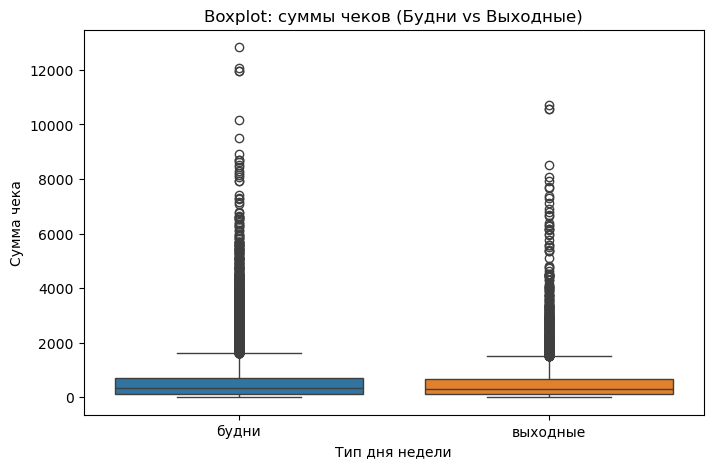

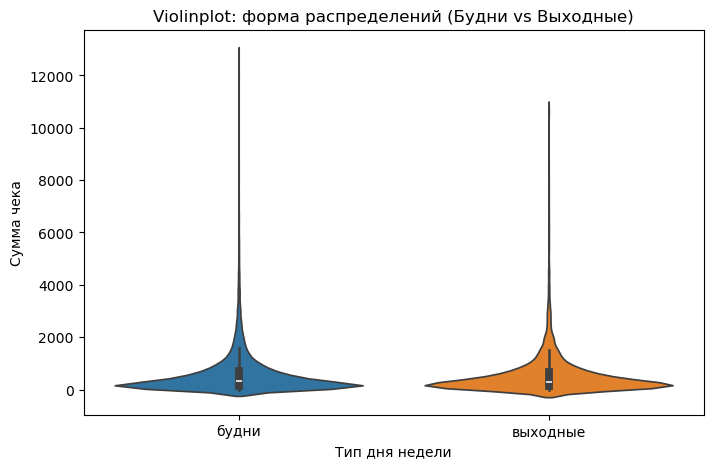

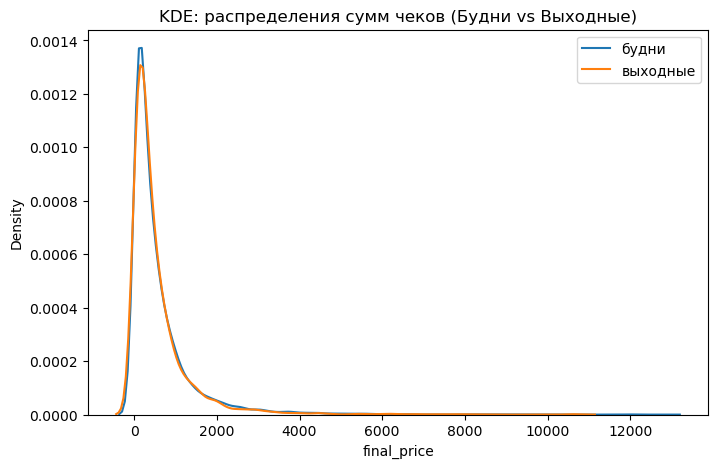

In [7]:
# === 2. Визуализация распределений ===
plt.figure(figsize=(8, 5))
sns.boxplot(x="week_type", y="final_price",hue ="week_type", data=grouped)
plt.title("Boxplot: суммы чеков (Будни vs Выходные)")
plt.xlabel("Тип дня недели")
plt.ylabel("Сумма чека")
plt.show()
 
plt.figure(figsize=(8, 5))
sns.violinplot(x="week_type", y="final_price",hue ="week_type", data=grouped)
plt.title("Violinplot: форма распределений (Будни vs Выходные)")
plt.xlabel("Тип дня недели")
plt.ylabel("Сумма чека")
plt.show()
 
plt.figure(figsize=(8, 5))
for wt in grouped["week_type"].unique():
    subset = grouped[grouped["week_type"] == wt]["final_price"]
    sns.kdeplot(subset, label=wt, fill=False)
plt.title("KDE: распределения сумм чеков (Будни vs Выходные)")
plt.legend()
plt.show()

KDE-график (плотность распределения): распределения сумм чеков (Будни vs Выходные)
- Оба распределения имеют сильно правосторонний (асимметричный) хвост – большинство чеков сосредоточены вблизи нуля, и только небольшое количество уходит на очень большие значения.
- Формы KDE-графиков для будней и выходных очень похожи, различия минимальны и в основном касаются амплитуды пика.
- Это говорит о сходстве формы распределений, хотя и с возможными небольшими отличиями в плотности.

Boxplot (ящик с усами): суммы чеков (Будни vs Выходные)
- В обеих группах наблюдаются многочисленные выбросы, что логично для правосторонне распределённых данных.
- Медианы (центральные линии в коробках) почти совпадают, хотя медиана в будние дни, возможно, немного выше.
- Диапазоны межквартильных размахов также очень похожи.

Violinplot: форма распределений (Будни vs Выходные)
- Violinplot сочетает KDE и boxplot, хорошо отображая плотность данных.
- Видно, что распределения очень схожи по форме, с основным скоплением данных ближе к нулю и «хвостами» в сторону больших значений.
- Структура и плотность распределения повторяются между буднями и выходными, без значительных отличий.

## Mann–Whitney U-test

### Проверка предпосылок

- Все три графика показывают, что форма распределений сумм чеков в будни и выходные практически одинакова.   
- Основное отличие может быть только в масштабе плотности или частоте экстремальных значений, но не в общей структуре.
- Применение Mann–Whitney U-test и Kruskal–Wallis test возможно.

### Проведение теста

In [8]:
# Данные
weekday_sales = grouped[grouped["week_type"] == "будни"]["final_price"]
weekend_sales = grouped[grouped["week_type"] == "выходные"]["final_price"]

# --- Mann–Whitney U test ---
u_stat, p_value = stats.mannwhitneyu(weekday_sales, weekend_sales, alternative="two-sided")

print("=== Mann–Whitney U Test ===")
print(f"U-statistic = {u_stat:.4f}, p-value = {p_value:.4e}")

# --- Rank-biserial correlation (размер эффекта) ---
# Формула: r_rb = 1 - (2U / (n1 * n2))
n1, n2 = len(weekday_sales), len(weekend_sales)
r_rb = 1 - (2 * u_stat) / (n1 * n2)

print("\n=== Effect size: Rank-biserial correlation ===")
print(f"r = {r_rb:.4f}")

# Интерпретация эффекта (по аналогии с корреляцией)
if abs(r_rb) < 0.1:
    strength = "пренебрежимо малый эффект"
elif abs(r_rb) < 0.3:
    strength = "малый эффект"
elif abs(r_rb) < 0.5:
    strength = "средний эффект"
else:
    strength = "крупный эффект"

print(f"Интерпретация: {strength}")

=== Mann–Whitney U Test ===
U-statistic = 42368033.0000, p-value = 6.1402e-02

=== Effect size: Rank-biserial correlation ===
r = -0.0171
Интерпретация: пренебрежимо малый эффект


## Kruskal–Wallis test

In [9]:
# Данные
weekday_sales = grouped[grouped["week_type"] == "будни"]["final_price"]
weekend_sales = grouped[grouped["week_type"] == "выходные"]["final_price"]

# --- 1. Kruskal–Wallis test ---
stat, p = stats.kruskal(weekday_sales, weekend_sales)

print("=== Kruskal–Wallis Test ===")
print(f"H-statistic = {stat:.4f}, p-value = {p:.4e}")

# --- 2. Эффект размера: Epsilon squared (ε²) ---
# Формула: ε² = (H - k + 1) / (n - k)
# где H — значение критерия, k — число групп, n — общее число наблюдений

k = 2  # будни и выходные
n = len(weekday_sales) + len(weekend_sales)
epsilon_sq = (stat - k + 1) / (n - k)

print("\n=== Effect size (Epsilon squared) ===")
print(f"Epsilon squared = {epsilon_sq:.4f}")

# Интерпретация силы эффекта:
if epsilon_sq < 0.01:
    strength = "очень слабый эффект"
elif epsilon_sq < 0.06:
    strength = "слабый эффект"
elif epsilon_sq < 0.14:
    strength = "средний эффект"
else:
    strength = "сильный эффект"

print(f"Интерпретация: {strength}")

=== Kruskal–Wallis Test ===
H-statistic = 3.4991, p-value = 6.1402e-02

=== Effect size (Epsilon squared) ===
Epsilon squared = 0.0001
Интерпретация: очень слабый эффект


**Результат** 
- p-value ≈ 0.061 означает, что при стандартном уровне значимости α = 0.05, различие не является статистически значимым.
- Даже если бы результат был статистически значим, размер эффекта крайне мал (и в Mann–Whitney, и в Kruskal–Wallis).
- Следовательно, различие между суммами чеков в будние и выходные дни почти отсутствует как в статистическом, так и в практическом смысле.

**Значение для бизнеса**   
Суммы покупок клиентов в будние и выходные дни практически не отличаются.
- Средний чек остаётся стабильным независимо от дня недели.
- Нет необходимости менять стратегию ценообразования, скидок или маркетинга в зависимости от типа дня.
- Акции или рекламные кампании, направленные на увеличение среднего чека, не требуют дифференциации по дням недели, так как поведение покупателей по чекам схоже.

ОГОВОРКА:   
Приведённые выводы справедливы при сохранении исходного контекста, в котором были собраны данные, включая параметры ценообразования, формат аптек, маркетинговую политику и другие бизнес-факторы. Изменения в этих условиях могут повлиять на применимость результатов.